In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from torch.autograd import Variable

from torch import optim
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

from torch.distributions.normal import Normal
from matplotlib import gridspec
import acquisition_function as acqf
import discrete_mes as mes
import discrete_ucb as ucb
import discrete_ei as ei
import discrete_pi as pi
import itertools

from dimension import Real,Integer, Categorical,Dimension
from bayesian_optimization import BayesianOptimization
%matplotlib inline
%load_ext autoreload
%autoreload 2

torch.cuda.set_device(3)

In [2]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # Our mean function is constant in the interval [-5,15]
        self.mean_module = ConstantMean(constant_bounds=(-5,15))
        # We use the RBF kernel as a universal approximator
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-6, 6))
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        # Return model output as GaussianRandomVariable
        return GaussianRandomVariable(mean_x, covar_x)

In [3]:
#minimize target function
def target(x):
    return -1*(3* torch.exp(-(x - 2)**2) + 2*torch.exp(-(x - 6)**2/8) + 1/ (x**2 + 1)+torch.randn(x.size()) * .1 )


# Training data is 6 points in [-5,15] inclusive regularly spaced
train_x = Variable(torch.linspace(-5, 15, 6))
# True function with Gaussian noise N(0,0.01)
# Maximize the negative target function
train_y = Variable(-1*target(train_x))

likelihood = GaussianLikelihood(log_noise_bounds=(-8, -6))
model = ExactGPModel(train_x.data, train_y.data, likelihood)

search_space = [Real(-5,15)]

In [4]:
#train before optimization
model.train()
likelihood.train()
optimizer = torch.optim.Adam([
        {'params': model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=0.1)
    # "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 10
for i in range(training_iter):
        # Zero gradients from previous iteration
    optimizer.zero_grad()
        # Output from model
    output = model(train_x)
        # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()

    print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f   log_noise: %.3f' % (
        i + 1, training_iter, loss.data[0],
        model.covar_module.log_lengthscale.data[0, 0],
        model.likelihood.log_noise.data[0]
        ))
  
    optimizer.step()


Iter 1/10 - Loss: 3.975   log_lengthscale: 0.000   log_noise: -6.000
Iter 2/10 - Loss: 3.907   log_lengthscale: 0.100   log_noise: -6.000
Iter 3/10 - Loss: 3.914   log_lengthscale: 0.197   log_noise: -6.000
Iter 4/10 - Loss: 3.937   log_lengthscale: 0.277   log_noise: -6.000
Iter 5/10 - Loss: 3.952   log_lengthscale: 0.363   log_noise: -6.000
Iter 6/10 - Loss: 3.941   log_lengthscale: 0.446   log_noise: -6.000
Iter 7/10 - Loss: 3.913   log_lengthscale: 0.533   log_noise: -6.000
Iter 8/10 - Loss: 3.863   log_lengthscale: 0.620   log_noise: -6.000
Iter 9/10 - Loss: 3.790   log_lengthscale: 0.711   log_noise: -6.000
Iter 10/10 - Loss: 3.711   log_lengthscale: 0.802   log_noise: -6.002


In [5]:
bo = BayesianOptimization(model, likelihood, target, search_space,"discrete_mes")

Iter 1/20 - Loss: 2.802   log_lengthscale: 0.896   log_noise: -6.036
Iter 2/20 - Loss: 3.143   log_lengthscale: 0.796   log_noise: -6.000
Iter 3/20 - Loss: 3.071   log_lengthscale: 0.842   log_noise: -6.000
Iter 4/20 - Loss: 2.989   log_lengthscale: 0.914   log_noise: -6.000
Iter 5/20 - Loss: 2.892   log_lengthscale: 0.963   log_noise: -6.000
Iter 6/20 - Loss: 2.946   log_lengthscale: 0.968   log_noise: -6.000
Iter 7/20 - Loss: 3.096   log_lengthscale: 0.935   log_noise: -6.000
Iter 8/20 - Loss: 3.215   log_lengthscale: 0.898   log_noise: -6.000
Iter 9/20 - Loss: 3.295   log_lengthscale: 0.899   log_noise: -6.000
Iter 10/20 - Loss: 3.537   log_lengthscale: 0.907   log_noise: -6.000
Iter 11/20 - Loss: 3.477   log_lengthscale: 0.931   log_noise: -6.000
Iter 12/20 - Loss: 3.483   log_lengthscale: 0.947   log_noise: -6.000
Iter 13/20 - Loss: 3.875   log_lengthscale: 0.957   log_noise: -6.000
Iter 14/20 - Loss: 3.570   log_lengthscale: 0.973   log_noise: -6.000
Iter 15/20 - Loss: 3.704   lo

Iter 1/20 - Loss: 1.294   log_lengthscale: -0.354   log_noise: -6.227
Iter 2/20 - Loss: 1.534   log_lengthscale: -0.254   log_noise: -6.327
Iter 3/20 - Loss: 1.216   log_lengthscale: -0.172   log_noise: -6.427
Iter 4/20 - Loss: 1.367   log_lengthscale: -0.117   log_noise: -6.527
Iter 5/20 - Loss: 1.462   log_lengthscale: -0.100   log_noise: -6.619
Iter 6/20 - Loss: 1.845   log_lengthscale: -0.119   log_noise: -6.684
Iter 7/20 - Loss: 1.604   log_lengthscale: -0.125   log_noise: -6.714
Iter 8/20 - Loss: 1.854   log_lengthscale: -0.140   log_noise: -6.721
Iter 9/20 - Loss: 1.865   log_lengthscale: -0.172   log_noise: -6.707
Iter 10/20 - Loss: 2.003   log_lengthscale: -0.213   log_noise: -6.687
Iter 11/20 - Loss: 1.885   log_lengthscale: -0.256   log_noise: -6.653
Iter 12/20 - Loss: 2.086   log_lengthscale: -0.296   log_noise: -6.633
Iter 13/20 - Loss: 2.505   log_lengthscale: -0.305   log_noise: -6.616
Iter 14/20 - Loss: 2.103   log_lengthscale: -0.300   log_noise: -6.589
Iter 15/20 - Lo

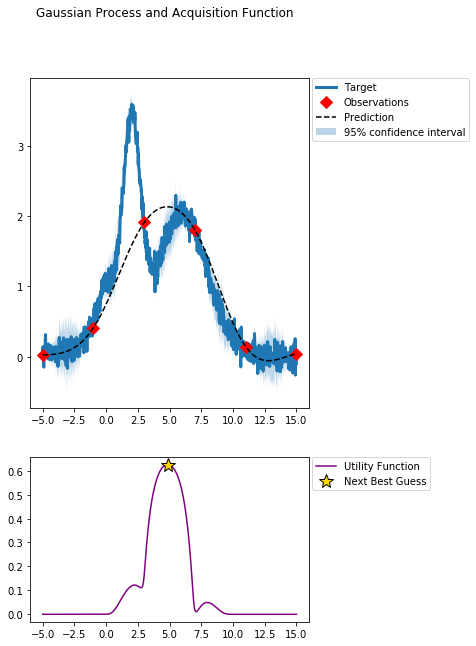

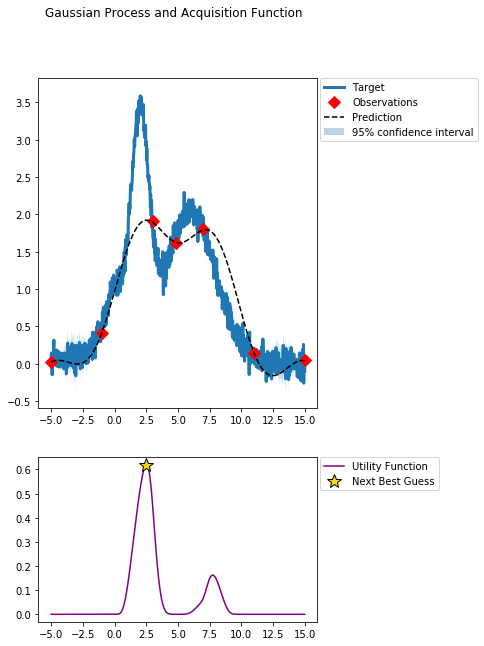

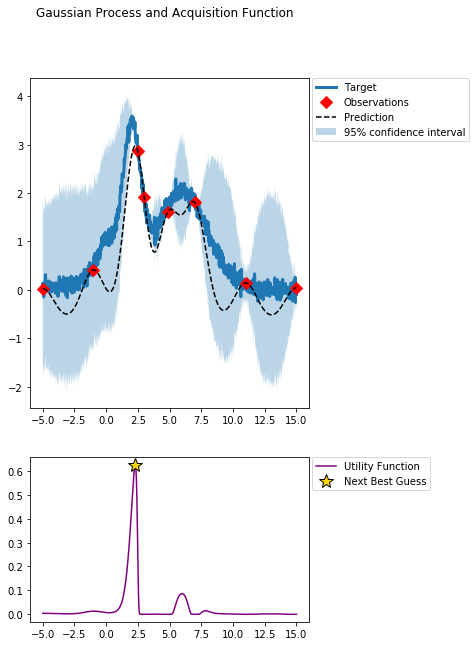

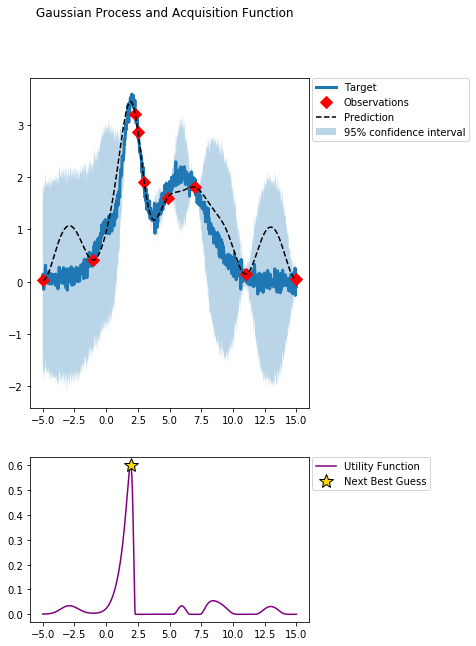

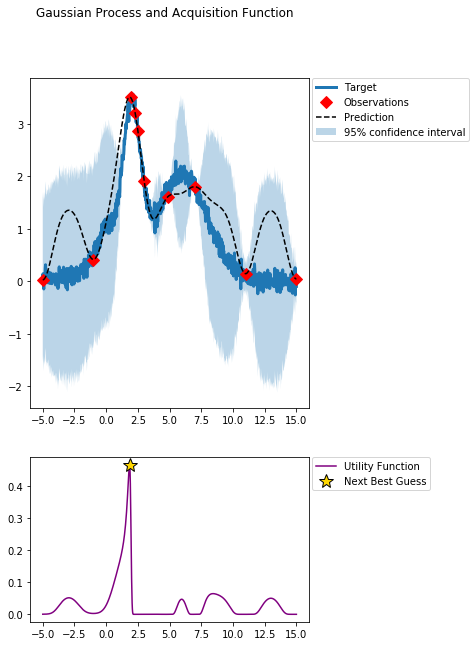

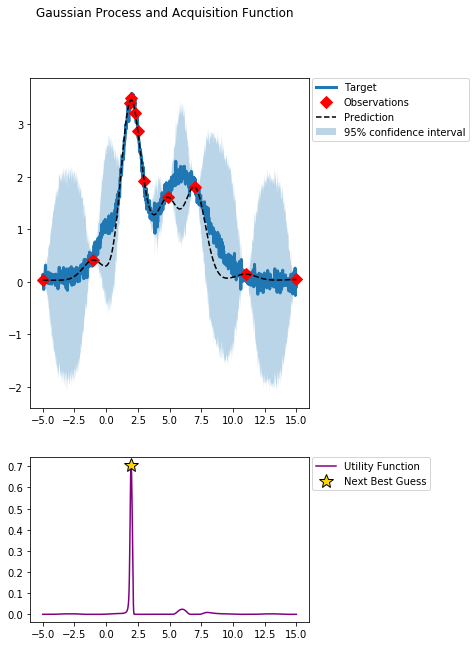

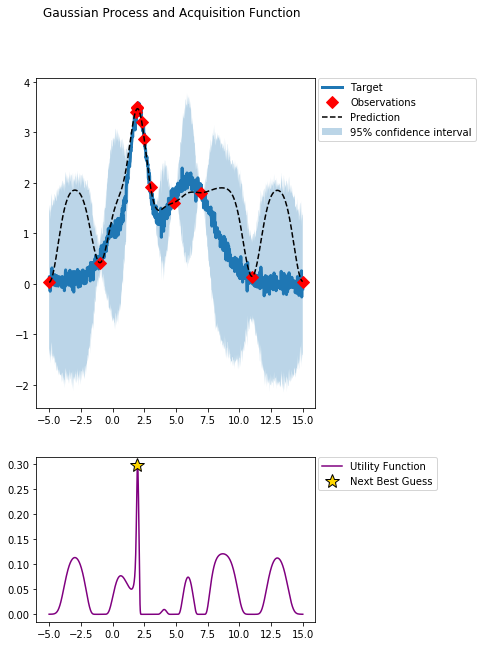

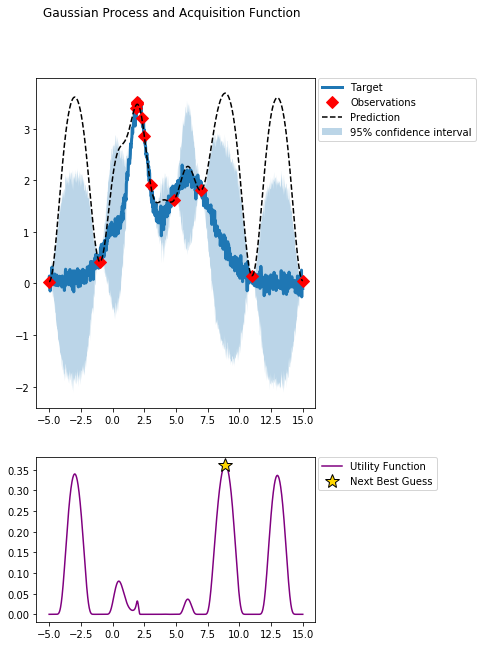

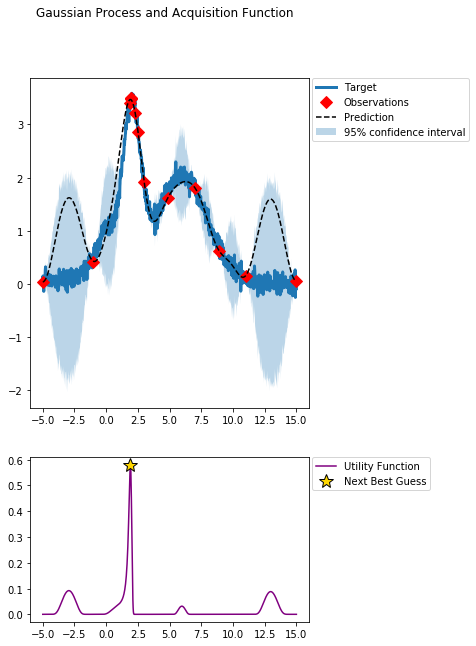

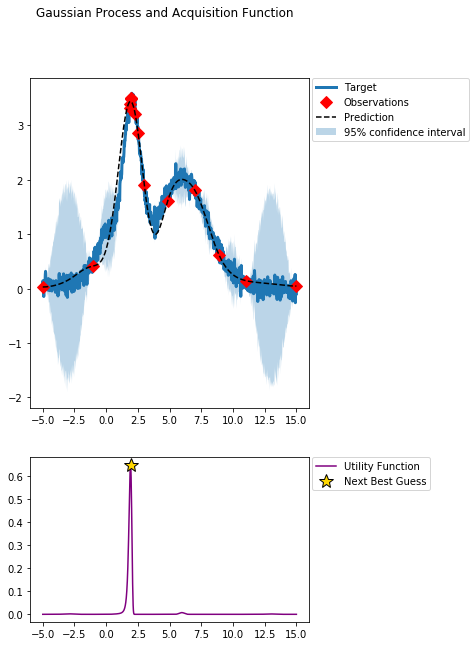

In [6]:
bo.optimal(10,plot=True)

In [7]:
print(bo.x_star)
print(bo.y_star.view(-1))

tensor([ 2.0270])
tensor([-3.5882])


In [8]:
train_x = torch.tensor([[1,99,55],[2,98,44]])
tuple(tri.unsqueeze(-1) if tri.ndimension() == 1 else tri for tri in (train_x,))[0].size()

torch.Size([2, 3])